In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
from  seaborn import heatmap
import matplotlib.pyplot as pl
import numpy as np
from matplotlib import rcParams
import pickle
from IPython.core.display import HTML, display
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
display(HTML("<style>.container{width:90% !important}</style>"))

In [3]:
%matplotlib inline

In [4]:
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.titlesize'] = 18
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 18

In [5]:
with open('./PklJar/TrainSet.pkl', 'rb') as f:
    trainFrames = pickle.load(f)
    
dfTrainFeatures = trainFrames['features']
dfTrainLabels = trainFrames['labels']

In [6]:
dfTrFeats = dfTrainFeatures.copy()

In [7]:
def GetRrsIdx(df, label_list=None):
    if label_list:
        return [df.columns.get_loc(label) for label in label_list]
    else:
        return [df.columns.get_loc(col) for col in df.filter(like='Rrs', axis=1).columns]

class BandRatioAdder(BaseEstimator, TransformerMixin):
    """ class to add attributes. """
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        band_ratio_531_443 = X[:, rrs531_ix] / X[:, rrs443_ix]
        band_ratio_555_443 = X[:, rrs555_ix] / X[:, rrs443_ix]
        return np.c_[X, band_ratio_531_443, band_ratio_555_443]


class RrsLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X[:, rrs_ix_list] = np.log(X[:, rrs_ix_list])
        return X

In [8]:
rrs443_ix, rrs531_ix, rrs555_ix = GetRrsIdx(dfTrainFeatures, label_list=['Rrs443',
                                                                         'Rrs531', 
                                                                         'Rrs555'])
rrs_ix_list = GetRrsIdx(dfTrainFeatures)
rrs_ix_list = rrs_ix_list + [rrs_ix_list[-1] + 1, rrs_ix_list[-1] + 2]

Because of the histogram shapes (see the "DOC_4" notebook), features used to predict doc and ag_412 will only be standardized. These will however be log-transformed then standardized for prediction of s300_600

In [9]:
doc_ag412_pipeline = Pipeline([('imputer', Imputer(strategy='median')),
                               ('br_adder', BandRatioAdder()),
                               ('std_scaler', StandardScaler())])

s300_600_pipeline = Pipeline([('imputer', Imputer(strategy='median')),
                             ('br_adder', BandRatioAdder()),
                             ('rrs_logter', RrsLogTransformer()),
                             ('std_scaler', StandardScaler())])

In [10]:
x1_tr = doc_ag412_pipeline.fit_transform(dfTrFeats.values)

In [11]:
x2_tr = s300_600_pipeline.fit_transform(dfTrFeats.values)

In [12]:
df1 = pd.DataFrame(x1_tr, columns=dfTrFeats.columns.tolist() + ['br531_443', 'br555_443'])
df2 = pd.DataFrame(x2_tr, columns=dfTrFeats.columns.tolist() + ['br531_443', 'br555_443'])

Pickling pipelines and dataframes:

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 9 columns):
SST          223 non-null float64
SSS          223 non-null float64
Rrs412       223 non-null float64
Rrs443       223 non-null float64
Rrs531       223 non-null float64
Rrs555       223 non-null float64
Rrs667       223 non-null float64
br531_443    223 non-null float64
br555_443    223 non-null float64
dtypes: float64(9)
memory usage: 15.8 KB


In [13]:
df1.describe()

,SST,SSS,Rrs412,Rrs443,Rrs531,Rrs555,Rrs667,br531_443,br555_443
count,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02
mean,1.929199e-16,2.170660e-16,2.200532e-16,9.359728e-17,-1.585677e-16,5.439097e-17,-4.381149e-17,7.667011e-17,2.656072e-16
std,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00
min,-2.032556e+00,-3.964308e+00,-1.126934e+00,-1.286548e+00,-1.254739e+00,-1.213438e+00,-8.864499e-01,-1.497364e+00,-1.333654e+00
25%,-6.792651e-01,-6.082725e-01,-5.846346e-01,-5.235394e-01,-8.503447e-01,-8.464128e-01,-7.104298e-01,-8.217650e-01,-8.159229e-01
50%,-2.312177e-01,4.543054e-01,-1.828298e-01,-2.083937e-01,-2.884832e-01,-1.818094e-01,-3.537714e-01,-8.601386e-02,-1.484154e-01
75%,6.995099e-01,7.459684e-01,2.398998e-01,1.825091e-01,5.801132e-01,5.690813e-01,3.763035e-01,5.404712e-01,5.827710e-01
max,2.087990e+00,1.189751e+00,7.782521e+00,6.126143e+00,3.541864e+00,3.126624e+00,7.282350e+00,7.435127e+00,7.826025e+00


In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 9 columns):
SST          223 non-null float64
SSS          223 non-null float64
Rrs412       223 non-null float64
Rrs443       223 non-null float64
Rrs531       223 non-null float64
Rrs555       223 non-null float64
Rrs667       223 non-null float64
br531_443    223 non-null float64
br555_443    223 non-null float64
dtypes: float64(9)
memory usage: 15.8 KB


In [14]:
df2.describe()

,SST,SSS,Rrs412,Rrs443,Rrs531,Rrs555,Rrs667,br531_443,br555_443
count,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02,2.230000e+02
mean,1.929199e-16,2.170660e-16,5.028364e-17,-7.607268e-16,-2.918069e-16,-8.364012e-16,1.787310e-16,-1.329280e-16,-1.045502e-17
std,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00,1.002250e+00
min,-2.032556e+00,-3.964308e+00,-7.889190e+00,-3.091637e+00,-2.167281e+00,-1.987787e+00,-2.033973e+00,-2.729094e+00,-2.747153e+00
25%,-6.792651e-01,-6.082725e-01,-4.390739e-01,-4.487043e-01,-9.732592e-01,-8.973857e-01,-8.519427e-01,-8.665426e-01,-8.647807e-01
50%,-2.312177e-01,4.543054e-01,1.511293e-01,3.400865e-02,-5.036298e-02,1.178011e-01,1.983736e-02,1.510660e-01,1.429352e-01
75%,6.995099e-01,7.459684e-01,5.451300e-01,4.898375e-01,8.146730e-01,7.947532e-01,7.997197e-01,7.372334e-01,7.987598e-01
max,2.087990e+00,1.189751e+00,2.541823e+00,3.090821e+00,2.307828e+00,2.029957e+00,2.599130e+00,3.415762e+00,3.117892e+00


In [49]:
def MakeHeatmap(df_features, df_labels, title=None):
    dfall = pd.concat((df_features, df_labels.reset_index()), axis=1)
    f, ax = pl.subplots(figsize=(12,12))
    heatmap(dfall.corr(), annot=True,
           mask=np.triu(np.ones((dfall.shape[1], dfall.shape[1])), k=1))
    ax.set_title(title);

In [34]:
df1l = dfTrainLabels.drop('s300-600', axis=1)

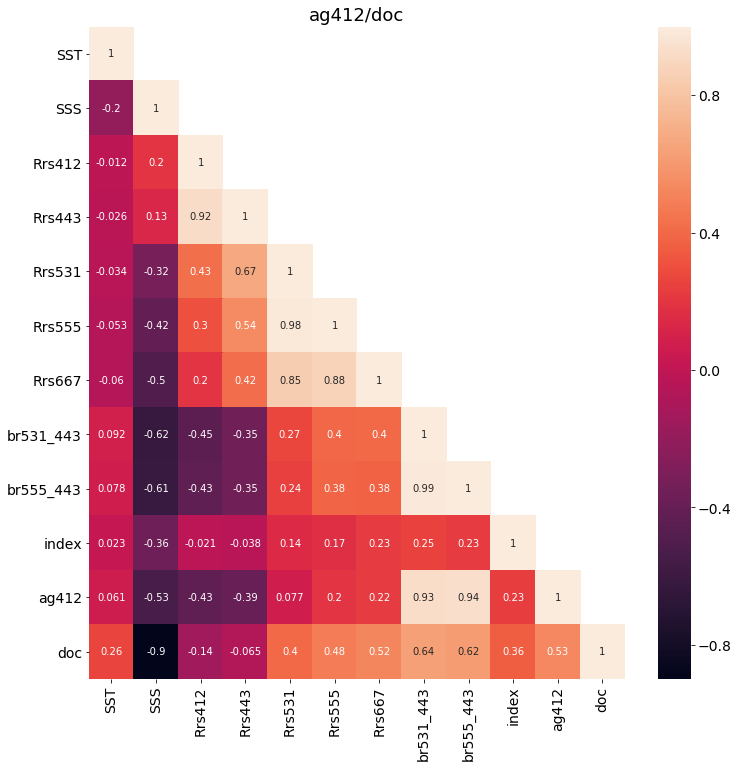

In [47]:
MakeHeatmap(df1, df1l, title='ag412/doc')

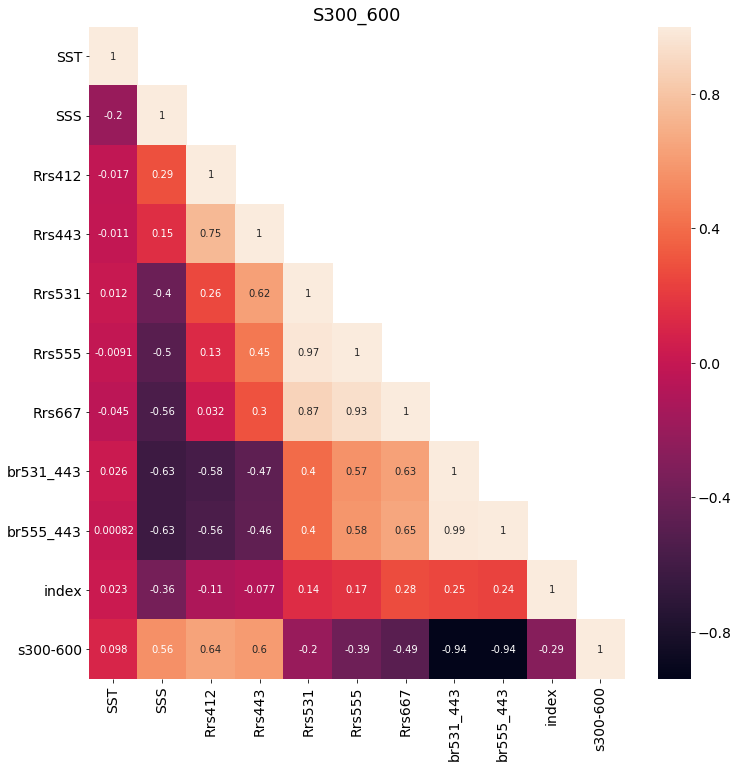

In [48]:
df2l = dfTrainLabels['s300-600']
MakeHeatmap(df2, df2l, title='S300_600')